In [3]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import os
from sklearn.metrics import log_loss
random.seed(42)
d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)

# 할 일
1. income_total: 2.2
2. begin_month: 1.7
3. DAYS_BIRTH : 2.1
4. DAYS_EMPLOYED : 2.8

In [ ]:
github/kaggle/credit_card/no_dup.csv

In [69]:
c = 'DAYS_EMPLOYED'
result = []
for i,k in enumerate(range(150,401,10)):
    k = 0.01 * k
    

    train = pd.read_csv('c:/github/kaggle/credit_card/no_dup.csv')
    train = train.drop(['index','identity'], axis=1)
    train.fillna('NAN', inplace=True) 
    
    train = train.loc[train['DAYS_EMPLOYED']<=0]
    train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: round(abs(x)**(1/3),1))



    # Married, Civil marriage
    train['income_per_size'] = np.log(train['income_total']/train['family_size'])
#     test['income_per_size'] = np.log(test['income_total']/test['family_size'])
    train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
    = train['income_per_size'] * 2
#     test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
#     = test['income_per_size'] * 2

    def simple_marry(x):
        if x == 'Married' or x =='Civil marriage':
            return '0'
        elif x == 'Separated' or x == 'Widow':
            return '1'
        else:
            return '2'
    # 안 덮어쓰기
#     for df in [train,test]:
    for df in [train]:
        df['family_bins'] = df['family_type'].apply(simple_marry)

    ### 여기서부터

    train['income_total'] = np.log(train['income_total'])
    
        # income_total mean, std 계산
    mean = train[c].mean()
    std = train[c].std()
    
    idxs = train.loc[(train[c]>= mean + k*std)|\
                    (train[c]<= mean - k*std)].index
    train = train.drop(idxs).reset_index(drop=True)
    



    # car와 reality를 합친 새로운 칼럼 careality
    train['car'] =train['car'].apply(lambda x: int(x=='Y'))
    train['reality'] =train['reality'].apply(lambda x: int(x=='Y'))
#     test['car'] =test['car'].apply(lambda x: int(x=='Y'))
#     test['reality'] =test['reality'].apply(lambda x: int(x=='Y'))

    train['careality'] = train['car'] + train['reality']
    train = train.drop(['car', 'reality'],1)

#     test['careality'] = test['car'] + test['reality']
#     test = test.drop(['car', 'reality'],1)
    
    
    
    
    object_col = []
    for col in train.columns:
        if train[col].dtype == 'object':
            object_col.append(col)

    enc = OneHotEncoder()
    enc.fit(train.loc[:,object_col])


    train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    train.drop(object_col, axis=1, inplace=True)
    train = pd.concat([train, train_onehot_df], axis=1)

#     test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
#                  columns=enc.get_feature_names(object_col))
#     test.drop(object_col, axis=1, inplace=True)
#     test = pd.concat([test, test_onehot_df], axis=1)
    
    
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    folds=[]
    losses=[]
    for train_idx, valid_idx in skf.split(train, train['credit']):
        folds.append((train_idx, valid_idx))
    lgb_models={}
    for fold in range(5):
#         print(f'===================================={fold+1}============================================')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                             train['credit'][train_idx].values, train['credit'][valid_idx].values 
        lgb = LGBMClassifier(n_estimators=1000)
        lgb.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                early_stopping_rounds=30, verbose=False)
        lgb_models[fold]=lgb
        losses.append(log_loss(y_valid, lgb.predict_proba(X_valid)))
#         print(f'================================================================================\n\n')
    print(len(train), "개 남음")
    print(i,'번째', 'std*', k, sum(losses)/5)
    result.append([i,k,sum(losses)/5])
result = sorted(result, key= lambda x: x[2])

6193 개 남음
0 번째 std* 1.5 0.7895634113889687
6399 개 남음
1 번째 std* 1.6 0.7887688269120188
6590 개 남음
2 번째 std* 1.7 0.788547969080817
6744 개 남음
3 번째 std* 1.8 0.7884006306733321
6892 개 남음
4 번째 std* 1.9000000000000001 0.78913090548765
6994 개 남음
5 번째 std* 2.0 0.7898498431549783
7046 개 남음
6 번째 std* 2.1 0.7901200194511276
7091 개 남음
7 번째 std* 2.2 0.7901665803332908
7119 개 남음
8 번째 std* 2.3000000000000003 0.7885017313280378
7147 개 남음
9 번째 std* 2.4 0.7909271124826931
7168 개 남음
10 번째 std* 2.5 0.7909480529556586
7187 개 남음
11 번째 std* 2.6 0.7893948646809054
7203 개 남음
12 번째 std* 2.7 0.7883597184998601
7213 개 남음
13 번째 std* 2.8000000000000003 0.7870710216275666
7217 개 남음
14 번째 std* 2.9 0.7893228085610129
7222 개 남음
15 번째 std* 3.0 0.7887920925880036
7227 개 남음
16 번째 std* 3.1 0.7894010134588887
7229 개 남음
17 번째 std* 3.2 0.7911315389668528
7229 개 남음
18 번째 std* 3.3000000000000003 0.7911315389668528
7229 개 남음
19 번째 std* 3.4 0.7911315389668528
7229 개 남음
20 번째 std* 3.5 0.7911315389668528
7229 개 남음
21 번째 std* 3.6 0.79

In [70]:
result

[[13, 2.8000000000000003, 0.7870710216275666],
 [12, 2.7, 0.7883597184998601],
 [3, 1.8, 0.7884006306733321],
 [8, 2.3000000000000003, 0.7885017313280378],
 [2, 1.7, 0.788547969080817],
 [1, 1.6, 0.7887688269120188],
 [15, 3.0, 0.7887920925880036],
 [4, 1.9000000000000001, 0.78913090548765],
 [14, 2.9, 0.7893228085610129],
 [11, 2.6, 0.7893948646809054],
 [16, 3.1, 0.7894010134588887],
 [0, 1.5, 0.7895634113889687],
 [5, 2.0, 0.7898498431549783],
 [6, 2.1, 0.7901200194511276],
 [7, 2.2, 0.7901665803332908],
 [9, 2.4, 0.7909271124826931],
 [10, 2.5, 0.7909480529556586],
 [17, 3.2, 0.7911315389668528],
 [18, 3.3000000000000003, 0.7911315389668528],
 [19, 3.4, 0.7911315389668528],
 [20, 3.5, 0.7911315389668528],
 [21, 3.6, 0.7911315389668528],
 [22, 3.7, 0.7911315389668528],
 [23, 3.8000000000000003, 0.7911315389668528],
 [24, 3.9, 0.7911315389668528],
 [25, 4.0, 0.7911315389668528]]

In [65]:
round(16**(1/4),2)

2.0

In [44]:
result

[]

In [39]:
train = pd.read_csv('c:/github/kaggle/credit_card/no_dup.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,identity
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,...,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,F202500.0Commercial associate-13899-4709
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,F247500.0Commercial associate-11380-1540
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,...,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,M450000.0Working-19087-4434
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,F202500.0Commercial associate-15088-2092
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,...,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,F157500.0State servant-15037-2105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,26450,F,N,N,0,225000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-581,1,0,1,0,Laborers,1.0,-37.0,2.0,F225000.0Commercial associate-10338-581
8723,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,...,-2475,1,0,0,0,NaN,2.0,-47.0,2.0,F180000.0Working-15291-2475
8724,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,...,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0,F292500.0Working-10082-2015
8725,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,...,-107,1,0,0,0,Laborers,1.0,-59.0,2.0,M171000.0Working-10145-107


In [42]:
result = []

train = pd.read_csv('c:/github/kaggle/credit_card/no_dup.csv')
train = train.drop(['index','identity'], axis=1)
train.fillna('NAN', inplace=True) 

train = train.loc[train['DAYS_EMPLOYED']<=0]
# Married, Civil marriage
train['income_per_size'] = np.log(train['income_total']/train['family_size'])
#     test['income_per_size'] = np.log(test['income_total']/test['family_size'])
train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
= train['income_per_size'] * 2
#     test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
#     = test['income_per_size'] * 2

def simple_marry(x):
    if x == 'Married' or x =='Civil marriage':
        return '0'
    elif x == 'Separated' or x == 'Widow':
        return '1'
    else:
        return '2'
# 안 덮어쓰기
#     for df in [train,test]:
for df in [train]:
    df['family_bins'] = df['family_type'].apply(simple_marry)

### 여기서부터

train['income_total'] = np.log(train['income_total'])

    # income_total mean, std 계산
#     mean = train[c].mean()
#     std = train[c].std()

#     idxs = train.loc[(train[c]>= mean + k*std)|\
#                     (train[c]<= mean - k*std)].index
#     train = train.drop(idxs).reset_index(drop=True)




# car와 reality를 합친 새로운 칼럼 careality
train['car'] =train['car'].apply(lambda x: int(x=='Y'))
train['reality'] =train['reality'].apply(lambda x: int(x=='Y'))
#     test['car'] =test['car'].apply(lambda x: int(x=='Y'))
#     test['reality'] =test['reality'].apply(lambda x: int(x=='Y'))

train['careality'] = train['car'] + train['reality']
train = train.drop(['car', 'reality'],1)

#     test['careality'] = test['car'] + test['reality']
#     test = test.drop(['car', 'reality'],1)




# object_col = []
# for col in train.columns:
#     if train[col].dtype == 'object':
#         object_col.append(col)

# enc = OneHotEncoder()
# enc.fit(train.loc[:,object_col])


# train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# train.drop(object_col, axis=1, inplace=True)
# train = pd.concat([train, train_onehot_df], axis=1)

#     test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
#                  columns=enc.get_feature_names(object_col))
#     test.drop(object_col, axis=1, inplace=True)
#     test = pd.concat([test, test_onehot_df], axis=1)



# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# folds=[]
# losses=[]
# for train_idx, valid_idx in skf.split(train, train['credit']):
#     folds.append((train_idx, valid_idx))
# lgb_models={}
# for fold in range(5):
# #         print(f'===================================={fold+1}============================================')
#     train_idx, valid_idx = folds[fold]
#     X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
#                                          train['credit'][train_idx].values, train['credit'][valid_idx].values 
#     lgb = LGBMClassifier(n_estimators=1000)
#     lgb.fit(X_train, y_train, 
#             eval_set=[(X_train, y_train), (X_valid, y_valid)], 
#             early_stopping_rounds=30, verbose=False)
#     lgb_models[fold]=lgb
#     losses.append(log_loss(y_valid, lgb.predict_proba(X_valid)))
# #         print(f'================================================================================\n\n')
# print(len(train), "개 남음")
# print(sum(losses)/5)
# result.append([i,k,sum(losses)/5])
# result = sorted(result, key= lambda x: x[2])

In [43]:
train

,gender,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_per_size,family_bins,careality
0,F,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NAN,2.0,-6.0,1.0,23.050696,0,0
1,F,1,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,22.641107,0,1
2,M,0,13.017003,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,24.647711,0,2
3,F,0,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,23.050696,0,1
4,F,0,11.967181,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,22.548067,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,F,0,12.323856,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-10338,-581,1,0,1,0,Laborers,1.0,-37.0,2.0,12.323856,2,0
8723,F,1,12.100712,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NAN,2.0,-47.0,2.0,11.407565,1,1
8724,F,0,12.586220,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0,23.786146,0,1
8725,M,0,12.049419,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0,12.049419,2,1


In [37]:
train

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_NAN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,family_bins_0,family_bins_1,family_bins_2
0,0.0,12.218495,-13899.0,-4709.0,1.0,0.0,0.0,0.0,2.0,-6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,12.419166,-11380.0,-1540.0,1.0,0.0,0.0,1.0,3.0,-5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,13.017003,-19087.0,-4434.0,1.0,0.0,1.0,0.0,2.0,-22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.218495,-15088.0,-2092.0,1.0,0.0,1.0,0.0,2.0,-37.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,11.967181,-15037.0,-2105.0,1.0,0.0,0.0,0.0,2.0,-26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,0.0,12.323856,-10338.0,-581.0,1.0,0.0,1.0,0.0,1.0,-37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8723,1.0,12.100712,-15291.0,-2475.0,1.0,0.0,0.0,0.0,2.0,-47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8724,0.0,12.586220,-10082.0,-2015.0,1.0,0.0,0.0,0.0,2.0,-25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8725,0.0,12.049419,-10145.0,-107.0,1.0,0.0,0.0,0.0,1.0,-59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
train

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_NAN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,family_bins_0,family_bins_1,family_bins_2
0,0,12.218495,-13899,-4709,1,0,0,0,2.0,-6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,12.419166,-11380,-1540,1,0,0,1,3.0,-5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,13.017003,-19087,-4434,1,0,1,0,2.0,-22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,12.218495,-15088,-2092,1,0,1,0,2.0,-37.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,11.967181,-15037,-2105,1,0,0,0,2.0,-26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7224,0,12.323856,-10338,-581,1,0,1,0,1.0,-37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7225,1,12.100712,-15291,-2475,1,0,0,0,2.0,-47.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7226,0,12.586220,-10082,-2015,1,0,0,0,2.0,-25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7227,0,12.049419,-10145,-107,1,0,0,0,1.0,-59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
result

[[0, 1.5, 0.8515904847336714],
 [1, 1.55, 0.8515904847336714],
 [2, 1.6, 0.8515904847336714],
 [3, 1.6500000000000001, 0.8515904847336714],
 [4, 1.7, 0.8515904847336714],
 [5, 1.75, 0.8515904847336714],
 [6, 1.8, 0.8515904847336714],
 [7, 1.85, 0.8515904847336714],
 [8, 1.9000000000000001, 0.8515904847336714],
 [9, 1.95, 0.8515904847336714],
 [10, 2.0, 0.8515904847336714],
 [11, 2.05, 0.8515904847336714],
 [12, 2.1, 0.8515904847336714],
 [13, 2.15, 0.8515904847336714],
 [14, 2.2, 0.8515904847336714],
 [15, 2.25, 0.8515904847336714],
 [16, 2.3000000000000003, 0.8515904847336714],
 [17, 2.35, 0.8515904847336714],
 [18, 2.4, 0.8515904847336714],
 [19, 2.45, 0.8515904847336714],
 [20, 2.5, 0.8515904847336714],
 [21, 2.5500000000000003, 0.8515904847336714],
 [22, 2.6, 0.8515904847336714],
 [23, 2.65, 0.8515904847336714],
 [24, 2.7, 0.8515904847336714],
 [25, 2.75, 0.8515904847336714],
 [26, 2.8000000000000003, 0.8515904847336714],
 [27, 2.85, 0.8515904847336714],
 [28, 2.9, 0.85159048473367

# 전처리

### family_type
- 'Married', 'Civil marriage'
- 'Separated',  'Widow'
- 'Single / not married'

In [236]:
# Married, Civil marriage
train['income_per_size'] = np.log(train['income_total']/train['family_size'])
test['income_per_size'] = np.log(test['income_total']/test['family_size'])
train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
= train['income_per_size'] * 2

test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
= test['income_per_size'] * 2

In [237]:
def simple_marry(x):
    if x == 'Married' or x =='Civil marriage':
        return '0'
    elif x == 'Separated' or x == 'Widow':
        return '1'
    else:
        return '2'
# 안 덮어쓰기
for df in [train,test]:
    df['family_bins'] = df['family_type'].apply(simple_marry)

In [238]:
train['income_total'] = np.log(train['income_total'])
test['income_total'] = np.log(test['income_total'])

### 여기서부터

In [239]:
# income_total
mean = train['income_total'].mean()
std = train['income_total'].std()
idxs = train.loc[(train['income_total']>= mean + 0.71*std) |\
                (train['income_total']<= mean - 0.71*std)].index
train = train.drop(idxs).reset_index(drop=True)

In [240]:
### log_income == 0.71
### DAYS_BIRTH == 0.55
### DAYS_EMPLOYED == 0.08

mean = train['DAYS_BIRTH'].mean()
std = train['DAYS_BIRTH'].std()
idxs = train.loc[(train['DAYS_BIRTH']>= mean + 0.55*std) |\
                (train['DAYS_BIRTH']<= mean - 0.55*std)].index
train = train.drop(idxs).reset_index(drop=True)

In [241]:


mean = train['DAYS_EMPLOYED'].mean()
std = train['DAYS_EMPLOYED'].std()
idxs = train.loc[(train['DAYS_EMPLOYED']>= mean + 0.9*std) |\
                (train['DAYS_EMPLOYED']<= mean - 0.9*std)].index
train = train.drop(idxs).reset_index(drop=True)

In [217]:
len(train)

4988

### 여기까지

In [218]:
# income_total을 로그변환 한 새로운 feature log_income
# 기존 칼럼 삭제
# train['log_income'] = np.log(train['income_total'])
# test['log_income'] = np.log(test['income_total'])
# train.drop('log_income', 1, inplace=True)
# test.drop('log_income', 1, inplace=True)

In [242]:
# car와 reality를 합친 새로운 칼럼 careality
train['careality'] = train['car'] + train['reality']
train = train.drop(['car', 'reality'],1)

test['careality'] = test['car'] + test['reality']
test = test.drop(['car', 'reality'],1)

In [243]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

enc = OneHotEncoder()
total = pd.concat([train,test])
enc.fit(total.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

# 모델링, 학습

In [244]:
len(train.columns)

61

In [245]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
losses=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    losses.append(log_loss(y_valid, lgb.predict_proba(X_valid)))
    print(f'================================================================================\n\n')
print(sum(losses)/5)

====================================1============================================
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.489181	valid_1's multi_logloss: 0.746551


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.363473	valid_1's multi_logloss: 0.72872
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.429014	valid_1's multi_logloss: 0.720723


====================================3============================================
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.446596	valid_1's multi_logloss: 0.678179


====================================4============================================
Training until validation scores don't improve for 30 rounds
Early stopping, best 

In [ ]:
# 제거 전
0.7339955763587701

In [ ]:
# income_total 제거 후
0.7235526893647409

In [ ]:
# days_birth 제거 후  
0.7029433061193193

# train 8907건

In [166]:
# days_employed제거 후
0.7302461013939827

8907

In [ ]:
# income, birth
0.7124152348450041

In [ ]:
# income, employed
0.7192224841691373

In [ ]:
# birth employed    이거랑
0.7018053462974099

In [ ]:
# 3개 다            
0.7153731770908228

<AxesSubplot:xlabel='income_total', ylabel='Density'>

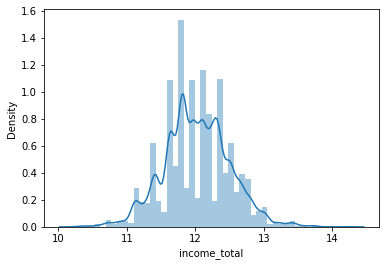

In [130]:
sns.distplot(train['income_total'])

<AxesSubplot:xlabel='income_total', ylabel='Density'>

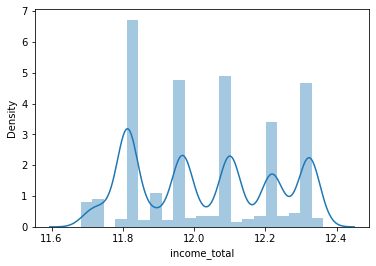

In [156]:
sns.distplot(train['income_total'])

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Density'>

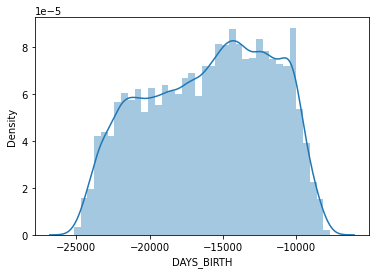

In [132]:
sns.distplot(train['DAYS_BIRTH'])

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Density'>

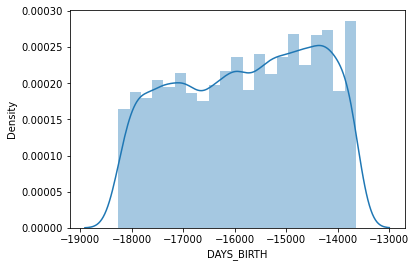

In [143]:
sns.distplot(train['DAYS_BIRTH'])

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

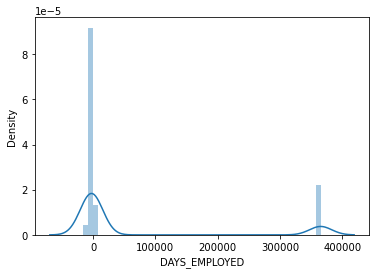

In [131]:
sns.distplot(train['DAYS_EMPLOYED'])

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

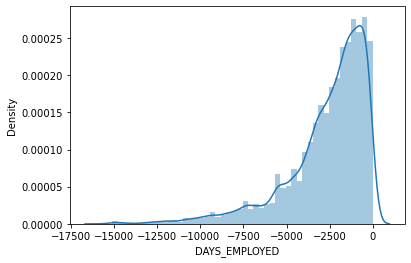

In [126]:
sns.distplot(train['DAYS_EMPLOYED'])

In [68]:
len(train)

8907

In [246]:
ss.iloc[:,1:]=0
for fold in range(5):
    ss.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [248]:
ss.to_csv('3out.csv', index=False)